# HMM with Example

Consider the latent state space model:

\begin{align*}
\theta &\sim \mathcal{N}(m, P) \\
x \mid \theta &\sim \mathcal{N}\bigl(C\,\theta,\; Q\bigr) \\
y \mid x &\sim \mathcal{N}\bigl(A\,x,\; R\bigr)
\end{align*}

Where $y$ is observed data, $x$ is latent, and we wish to infer on $\theta$

We first compute the likelihood of y, given by

$$
p(y\mid \theta)
\;=\;\int p(y\mid x)\,p(x\mid \theta)\,dx.
$$

$$
= \int \mathcal{N}\bigl(y; A\,x,\;R\bigr) \mathcal{N}\bigl(x; C\,\theta,\;Q\bigr) dx
$$

$$
= \mathcal{N}\!\Bigl(
y;\;A\,C\,\theta,\;A\,Q\,A^\top + R
\Bigr)
$$

Now we construct the posterior 

$$
p(\theta\mid y)
\propto
p(\theta) \; p(y\mid \theta)
$$

$$
\propto
\mathcal{N}\bigl(\theta; m \; P )
\;
\mathcal{N}\!\Bigl(
y;\;A\,C\,\theta,\;A\,Q\,A^\top + R
\Bigr)
$$

Using established result, we know

$$
p(\theta\mid y) = \mathcal{N}(y; M, \Sigma)
$$

Where the posterior covariance is given by

$$
\Sigma \;=\;
P - P (AC)^\top \Bigl( A\,Q\,A^\top + R + (AC) P (AC) ^\top \Bigr)^{-1} (AC) P
$$

Or equivalently in a more elegant form

$$
\Sigma \;=\;
\bigl[P^{-1} + C^\top A^\top (A\,Q\,A^\top + R)^{-1} A\,C\bigr]^{-1}.
$$ 

And the posterior mean $M$ is given by

$$
M = m + P (AC)^\top \Bigl( A\,Q\,A^\top + R + (AC) P (AC) ^\top \Bigr)^{-1} (y - ACm)
$$

or more elegantly

$$
M = \Sigma\bigl[P^{-1}m + C^\top A^\top (A\,Q\,A^\top + R)^{-1}y\bigr]
$$


As an example, consider the following parameters:

$$
m = \begin{pmatrix}2 \\[4pt] 0\end{pmatrix},\quad 
P = \begin{pmatrix}1 & 0\\[4pt] 0 & 1\end{pmatrix},\quad
C = \begin{pmatrix}1 & 1\\[4pt] 1 & 1.01\end{pmatrix}
$$

$$
Q = \begin{pmatrix}0.01 & 0\\[4pt] 0 & 0.01\end{pmatrix}
A = \begin{pmatrix}1 & 0 \\[4pt]\varepsilon & 0\end{pmatrix},\quad 
R = \,\begin{pmatrix}\varepsilon & 0\\[4pt] 0 & \varepsilon\end{pmatrix},\quad
$$

And we observed 
$
y = \begin{pmatrix}1\\[3pt]1\end{pmatrix}.
$

In this case we know the posterior is 

$$
p(\theta\mid y) = \mathcal{N}(y; M, \Sigma)
$$
Where $M, \Sigma$ depends on $\epsilon$ and is computed as follow:

In [1]:
import numpy as np
import pandas as pd

m = np.array([[2], [0]])
P = np.eye(2)
C = np.array([[1, 1], [1, 1.01]])
Q = 0.01 * np.eye(2)
y = np.array([[1], [1]])
A_base = np.array([[1, 0], [0, 0]], dtype=float)  # Base part of A
R_base = np.array([[1, 0], [0, 1]], dtype=float)  # Base part of R

epsilons = np.logspace(-3, 0, num=4)  # 10^-3, 10^-2, 10^-1, 10^0
post_var = []
post_means = []

for epsilon in epsilons:
    A = A_base.copy()
    A[1, 0] = epsilon  # Update A with the varying epsilon
    R = epsilon * R_base  # Update R with the varying epsilon
    S = A @ Q @ A.T + R

    Sigma = np.linalg.inv(P + C.T @ A.T @ np.linalg.inv(S) @ A @ C)
    post_var.append(np.round(Sigma, 4))

    post_mean = Sigma @ (np.linalg.inv(P) @ m + C.T @ A.T @ np.linalg.inv(S) @ y)
    post_means.append(np.round(post_mean.flatten(), 4)) # store 4 digits

# Create a DataFrame for visualization
df_post = pd.DataFrame(
    {"Epsilon": epsilons, 
    "Posterior Mean": post_means,
     "Posterior Variance": post_var}
    )
df_post

Epsilon     Posterior Mean                      Posterior Variance
0    0.001  [1.5032, -0.4968]  [[0.5027, -0.4973], [-0.4973, 0.5027]]
1    0.010  [1.5099, -0.4901]      [[0.505, -0.495], [-0.495, 0.505]]
2    0.100  [1.5681, -0.4319]  [[0.5258, -0.4742], [-0.4742, 0.5258]]
3    1.000  [1.6016, -0.3984]  [[0.6016, -0.3984], [-0.3984, 0.6016]]

With $\epsilon=1$, we have
$$
p(\theta\mid y) = \mathcal{N}(y; 
\begin{pmatrix}1.6 \\[4pt] -0.4 \end{pmatrix}, 
\begin{pmatrix}0.6 & -0.4 \\[4pt]-0.4 & 0.6\end{pmatrix}
)
$$

And we plot the posterior:

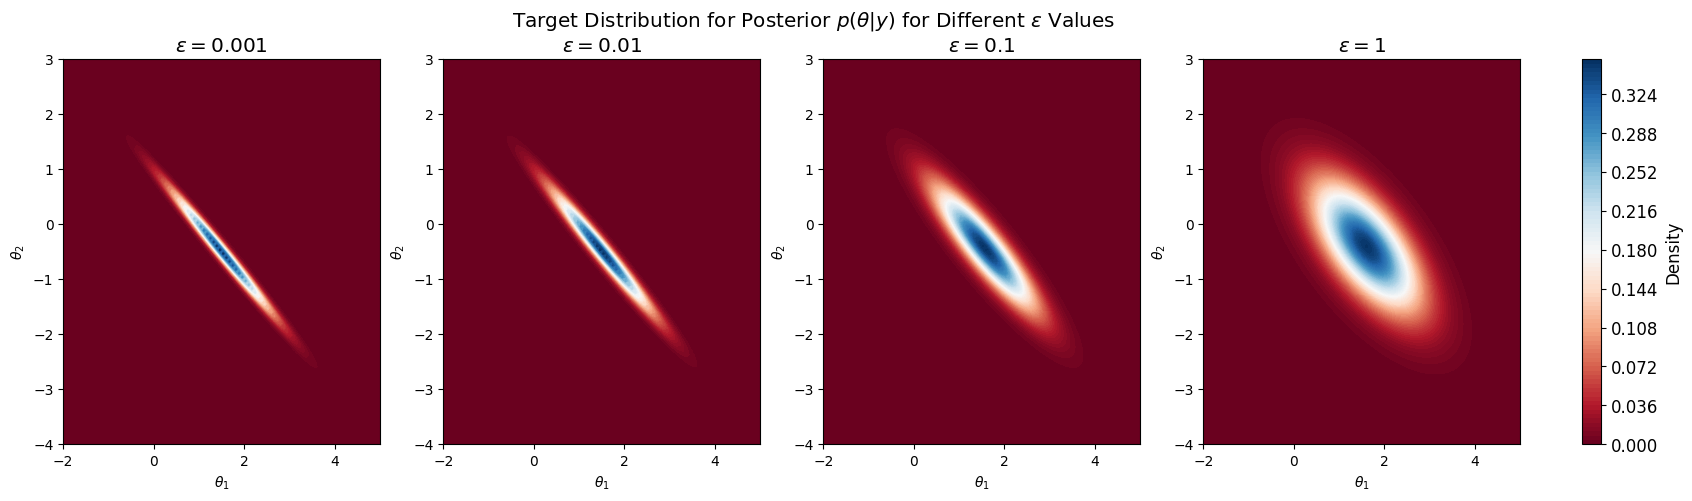

In [2]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Define grid for contour plot
x_bb = np.linspace(-2, 5, 100)
y_bb = np.linspace(-4, 3, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
plt.rcParams.update({'font.size': 12})  # Set font size

for i in df_post.index:
    eps = df_post['Epsilon'][i]
    post_mean = df_post['Posterior Mean'][i]
    post_var = df_post['Posterior Variance'][i]

    rv = multivariate_normal(mean=post_mean, cov=post_var)

    # Evaluate the posterior density on the grid
    pos = np.dstack((X_bb, Y_bb))
    Z_bb = rv.pdf(pos)

    # Plot the contour
    ax = axes[i]
    cnt = ax.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
    ax.set_title(f'$\\epsilon = {eps:.3g}$')
    ax.set_xlabel('$\\theta_1$')
    ax.set_ylabel('$\\theta_2$')

fig.colorbar(cnt, ax=axes, orientation='vertical', fraction=0.02, pad=0.04, label='Density')
plt.suptitle('Target Distribution for Posterior $p(\\theta | y)$ for Different $\\epsilon$ Values')
plt.show()


## Random Walk Metropolis Hastings (RWMH)

Now consider $\epsilon=1$. Recall that we have access to the true posterior:

$$
p(\theta\mid y) = \mathcal{N}(y; M, \Sigma)
$$

Suppose we only have access to the unnormalised posterior:

$$
p(\theta\mid y)
\propto
p(\theta) \; p(y\mid \theta)
$$

$$
\propto
\mathcal{N}\bigl(\theta; m \; P )
\;
\mathcal{N}\!\Bigl(
y;\;A\,C\,\theta,\;A\,Q\,A^\top + R
\Bigr)
$$

We can use RWMH to sample from the posterior $p(\theta | y)$

I use $x$ to denote $\theta$, and use $x_s$ to denote a new state for simplicity. 
My RWMH algorithm follows these steps:

1. **Initialize** at $x_0 = (0, 0)$, **fix** $\sigma_{\text{RW}}$
2. For each iteration:
   - **Propose** a new state under 
   $q(\theta' | \theta_{n-1}) = \mathcal{N}(\theta_{n-1}, 
   \sigma_{\text{rw}}) $
     $$ x_s = x_{n-1} + \sigma_{\text{rw}} \cdot \mathcal{N}(0, I) $$
   - **Compute acceptance probability**:  
     $$ a = \min\left(1, \frac{\pi(x_s)}{\pi(x_{n-1})} \right) $$
   - **Accept or reject**:
     - With probability $a$, set $x_n = x_s $.
     - Otherwise, set $ x_n = x_{n-1} $.

I set $\sigma_{\text{rw}} = 0.2 $.
If it's too small, proposals are close to the current state → slow exploration.  
Otherwise if too large, proposals often land in low-probability regions → high rejection rate.


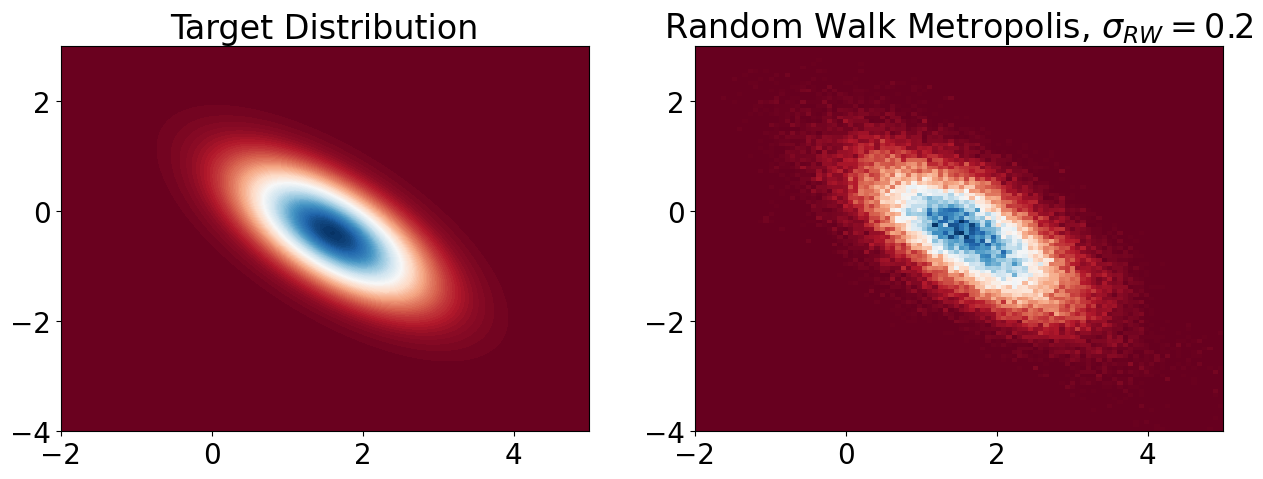

In [3]:
# Set random seed
rng = np.random.default_rng(24)

# Load posterior mean and variance
post_mean = df_post['Posterior Mean'][3]
post_var = df_post['Posterior Variance'][3]
rv = multivariate_normal(mean=post_mean, cov=post_var)

# Define log of the new target distribution
def logPi(x):
    return rv.logpdf(x)

# MCMC Sampling
def RWMH(logPi, sigma_rw = 0.5, N = 100000, burnin = 1000):
    samples_RW = np.zeros((2, N))
    samples_RW[:, 0] = np.array([0, 0])

    # Random Walk Metropolis-Hastings Algorithm
    for n in range(1, N):
        # Proposal sample from Gaussian random walk
        x_s = samples_RW[:, n-1] + sigma_rw * rng.normal(size=2)
        
        # Metropolis-Hastings acceptance step
        u = rng.uniform(0, 1)
        if np.log(u) < logPi(x_s) - logPi(samples_RW[:, n-1]):
            samples_RW[:, n] = x_s
        else:
            samples_RW[:, n] = samples_RW[:, n-1]
    return samples_RW

burnin = 1000
samples_RW = RWMH(logPi, sigma_rw = 0.2, burnin=burnin)

# Visualization
x_bb = np.linspace(-2, 5, 100)
y_bb = np.linspace(-4, 3, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
pos = np.dstack((X_bb, Y_bb))
Z_bb = rv.pdf(pos)

plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 20})

# Contour plot of target distribution
plt.subplot(1, 2, 1)
plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.title('Target Distribution')

# Histogram of sampled points
plt.subplot(1, 2, 2)
plt.hist2d(samples_RW[0, burnin:], samples_RW[1, burnin:], 
           100, cmap='RdBu', range=[[-2, 5], [-4, 3]], density=True)
plt.title('Random Walk Metropolis, $\\sigma_{RW} = 0.2$')
plt.show()

## Finding best proposal variance

We tune proposal variance $\sigma^2_{MH}$ between $10^{-4}$ to 4, and run RWMH with each variance.

Best sigma_rw: 1.2323100555166684


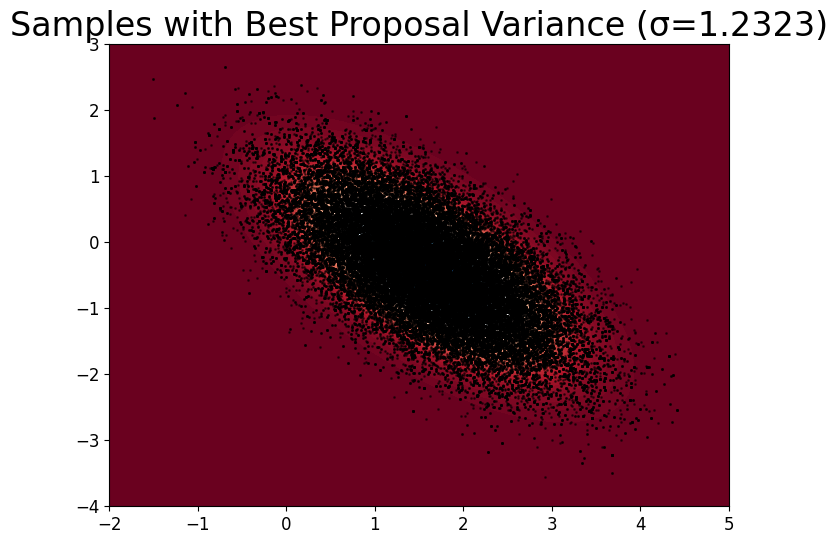

In [4]:
import statsmodels.api as sm

sigma_values = np.logspace(-4, np.log10(4), num=10)

acf_results = {} # Store results
samples_results = {}

for sigma_rw in sigma_values:
    samples_RW = RWMH(logPi, sigma_rw=sigma_rw, burnin=burnin)
    
    # Store results
    acf_results[sigma_rw] = sm.tsa.acf(samples_RW[0, burnin:], nlags=50)
    samples_results[sigma_rw] = samples_RW

# Find the best sigma_rw (lowest autocorrelation at lag 1)
best_sigma_rw = min(acf_results, key=lambda s: acf_results[s][1])
samples_RW_best = samples_results[best_sigma_rw]
print(f'Best sigma_rw: {best_sigma_rw}')

# Visualization
x_bb = np.linspace(-2, 5, 100)
y_bb = np.linspace(-4, 3, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)
pos = np.dstack((X_bb, Y_bb))
Z_bb = rv.pdf(pos)

plt.figure(figsize=(8, 6))
plt.tick_params(axis='y', labelsize=12) 
plt.tick_params(axis='x', labelsize=12)
plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.scatter(samples_RW_best[0, burnin:], samples_RW_best[1, burnin:],
             s=1, color='black', alpha=0.5)
plt.title(f'Samples with Best Proposal Variance (σ={best_sigma_rw:.4f})')
plt.xlim(-2, 5)
plt.ylim(-4, 3)
plt.show()


## Importance Sampler for Posterior

Suppose we don't even have access to the likelihood $p(y | \theta)$. 

We know that

$$
p(y \mid \theta)
=
\int_x p(y \mid x)\; p(x \mid \theta) dx
$$

$$
= \int_x p(y \mid x)\; 
\frac{p(x \mid \theta)}{q(x \mid \theta)} q(x \mid \theta) dx
$$

$$
= E_{q(x \mid \theta)} \;  \left[p(y \mid x)\;  
\frac{p(x \mid \theta)}{q(x \mid \theta)}\right]
$$

Where $ q(x \mid \theta) $ is our proposal

Hence we can sample $\{X_i\}_{i=1}^N$ from $ q(x \mid \theta) $,
then compute 
$$
\frac{1}{N} \sum_{i=1}^N
p(y \mid X_i)\;  \frac{p(X_i \mid \theta)}{q(X_i \mid \theta)}
$$
as an unbiased estimator of $p(y \mid \theta)$

We can also denote our estimator as
$$
\sum_{i=1}^N w_i \; p(y \mid X_i)
$$

Where
$ w_i = \frac{1}{N} \frac{p(X_i \mid \theta)}{q(X_i \mid \theta)} $ 
is the self-normalizing weight



In [5]:
# We re-define parameters again
epsilon = 1
theta = [0, 0]
y = [1, 1]

m = np.array([2, 0])
Q = np.array([[0.01, 0], [0, 0.01]])
P = np.array([[1, 0], [0, 1]])
C = np.array([[1, 1], [1, 1.01]])
A = np.array([[1, 0], [epsilon, 0]])
R = np.array([[epsilon, 0], [0, epsilon]])

def log_p_y_given_theta(y, theta):
    # true log density of y given theta
    mean = np.dot(A, np.dot(C, theta))
    cov = np.dot(A, np.dot(Q, A.T)) + R
    diff = y - mean
    return (-0.5 * np.dot(diff.T, np.linalg.inv(cov)).dot(diff) 
            - 0.5 * np.log(np.linalg.det(2 * np.pi * cov)))

def log_p_x_given_theta(x, theta):
    diff = x - np.dot(C, theta)
    return (-0.5 * np.dot(diff.T, np.linalg.inv(Q)).dot(diff) 
            - 0.5 * np.log(np.linalg.det(2 * np.pi * Q)))

def log_p_y_given_x(y, x):
    diff = y - np.dot(A, x)
    return (-0.5 * np.dot(diff.T, np.linalg.inv(R)).dot(diff) 
            - 0.5 * np.log(np.linalg.det(2 * np.pi * R)))

def log_p_theta(theta):
    diff = theta - m
    return (-0.5 * np.dot(diff.T, np.linalg.inv(P)).dot(diff) 
            - 0.5 * np.log(np.linalg.det(2 * np.pi * P)))

In [6]:
def logq(x, sig): # log-density of the proposal
    # proposal N(0, sig^2) in 2D
    return (- x[0]**2/(2 * sig**2) - x[1]**2/(2 * sig**2) 
            - np.log(2 * np.pi * sig**2))

# Self-normalised importance sampling of p(y|theta) 
def SNIS_for_loop(N, sig, theta=[0, 0]):
    '''Classical SNIS using a for loop'''
    # we used that y is fixed
    x_samples = rng.normal(0, sig, (N, 2)) # propose x
    logw = np.zeros(N) # log-weights
    phi_X = np.zeros(N)
    for i in range(N):
        logw[i] = (log_p_x_given_theta(x_samples[i, :], theta)
                    - logq(x_samples[i, :], sig))
        phi_X[i] = np.exp(log_p_y_given_x(y, x_samples[i, :]))
    logw = logw - np.max(logw) # to avoid numerical issues
    w = np.exp(logw)/np.sum(np.exp(logw)) # normalising the weights

    return np.dot(w, phi_X)

We also give a faster IS algorithm below, where we use vectorization to avoid the time-consuming for loop

In particular, since we know that $ \epsilon = 1$ 
and $ y = (1, 1) $ are fixed, 
we have the likelihood

$$
p(y \mid x) = \mathcal{N}(y; Ax, R)
= \mathcal{N}((1, 1); (x_1, x_1), I_2)
$$

We implement this in a vectorized way below

In [7]:
def p_y_given_x(x):
    """Compute the density of N((1,1); (x1, x1), I_2) for given x (N,2)."""
    mu = np.array([1, 1])  # Mean
    norm_const = 1 / (2 * np.pi)  # (1 / sqrt((2π)^2 * det(I_2)))
    diff = x - mu  # (N,2)
    exp_term = np.exp(-0.5 * np.sum(diff**2, axis=1))  # (N,)
    return norm_const * exp_term  # (N,)

def q(x, sig):
    # x has shape (N, 2)
    return multivariate_normal.pdf(x, mean=np.zeros(2), cov=sig**2 * np.eye(2))

def p_x_given_theta(x, theta):
    # x has shape (N, 2)
    return multivariate_normal.pdf(x, mean=np.dot(C, theta), cov=Q)

# we provide a new definition of IS with vectorization
def SNIS(N, sig, theta=[0, 0]):
    x_samples = rng.normal(0, sig, (N, 2)) # propose x
    
    # y | x likelihood
    phi_X = p_y_given_x(x_samples)
    # element wise division, w is (N, )
    w = p_x_given_theta(x_samples, theta) / q(x_samples, sig)
    return np.mean(w * phi_X)

# check result with SNIS with example run with sig=0.1
K, sig_ = 10000, 0.1
phi_SNIS = SNIS_for_loop(K, sig_  )
print('SNIS for loop:', phi_SNIS)
phi_SNIS_vec = SNIS(K, sig_)
print('SNIS vectorized:', phi_SNIS_vec)
true_lik = np.exp(log_p_y_given_theta(y, theta)) # true p(y|theta)
print('True likelihood:', true_lik)

SNIS for loop: 0.0590472992284872
SNIS vectorized: 0.058644608053991326
True likelihood: 0.05912091432281943


In [8]:
# Relative Absolute Error
def RAE(est):
    return np.abs(est - true_lik)/true_lik

## Pseudo-marginal Metropolis Hastings (PMMH)

We can plug this IS estimator into the MH ratio to obtain pseudo-marginal Metropolis Hastings (PMMH)

In our case we have

$$
p(\theta \mid y) \propto 
p(\theta) \; p(y \mid \theta)
$$

where we assume

$$
p(y \mid \theta)
=
\int_x p(y \mid x)\; p(x \mid \theta) dx
$$

$$
= \int_x p(y , x \mid \theta) dx
$$

is intractable, and can be replaced by the IS estimator 
$ \hat{p}(y|\theta) $ as described above (in 1.6 & 1.7)

We know $ p(y , x \mid \theta) $ can be computed pointwise
for any $ x, \theta $, since $ y $ is the fixed data.

Hence we can plug the IS estimator 
$ \hat{p}(y|\theta) $
 into the MH ratio to obtain the PMMH:

1. **Initialize** at $\theta_0 = (0, 0)$, 
**fix** $\sigma_{\text{MH}}$ and $\sigma_{\text{IS}}$

2. For each iteration:
   - **Propose** a new state under 
   $q(\theta' | \theta_{n-1}) = \mathcal{N}(\theta_{n-1}, \sigma_{\text{rw}}) $

    $$ \theta' = \theta_{n-1} + \sigma_{\text{MH}} \cdot \mathcal{N}(0, I) $$
   - **Run IS to compute likelihood under $\theta'$**:
   $\hat{p}(y|\theta')$ using the algo described above

   - **Compute acceptance probability**:  
    $$ 
    \alpha(\theta_{n-1}, \theta') = \min \left( 1, \frac{\hat{p}(y|\theta') p(\theta')(\theta_{n-1} | \theta')}{\hat{p}(y|\theta_{n-1}) p(\theta_{n-1}) q(\theta' | \theta{n-1})} \right)
    $$

    Note if we are using symmetric proposal 
    $ q(\theta' | \theta_{n-1}) = q(\theta_{n-1} | \theta')$,
    then the ratio becomes
    $$ 
    \alpha(\theta_{n-1}, \theta') = \min \left( 1, \frac{\hat{p}(y|\theta') p(\theta')}{\hat{p}(y|\theta_{n-1}) p(\theta_{n-1}) } \right)
    $$

   - **Accept or reject**:
     - With probability $a$, set $\theta_n = \theta' $.
     - Otherwise, set $ \theta_n = \theta_{n-1} $.

After tuning, we find out that `sig_IS=1, sig_MH=0.2` leads to the best result

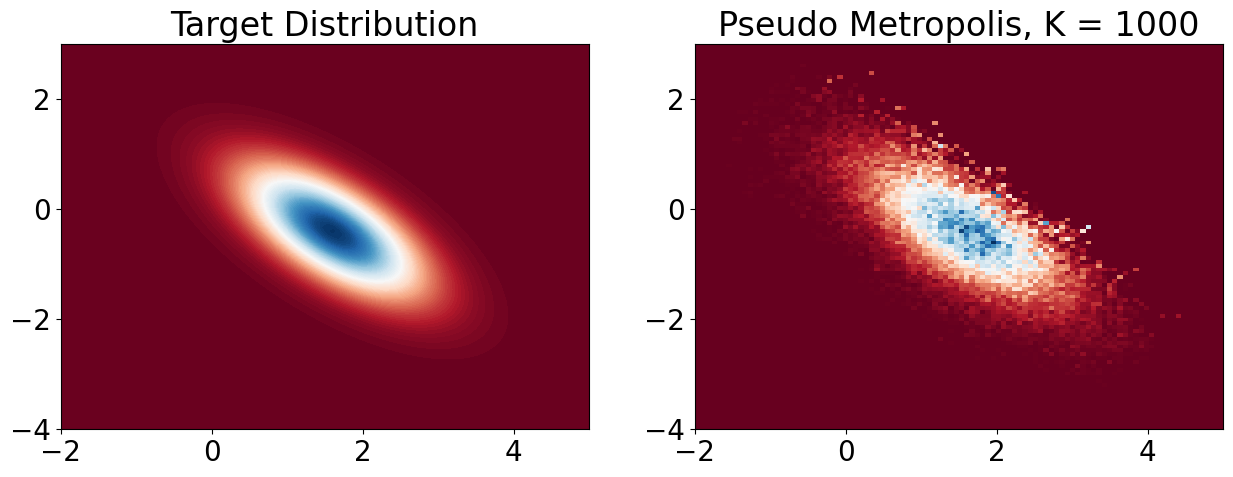

In [9]:
import statsmodels.api as sm

def PMMH(logPi, sig_IS, sig_MH, K = 10, 
         N = 100000, burnin = 5000, use_for_loop=False):
    # logPi is the prior logp(theta)

    sample_MH = np.zeros((2, N))
    sample_MH[:, 0] = np.array([0, 0])
    if use_for_loop:
        IS_lik = np.log(SNIS_for_loop(K, sig_IS, theta=sample_MH[:, 0]))
    else:
        IS_lik = np.log(SNIS(K, sig_IS, theta=sample_MH[:, 0]))

    for n in range(1, N):
        # Proposal sample from Gaussian random walk
        x_s = sample_MH[:, n-1] + sig_MH * rng.normal(size=2)

        # IS estimate of the log likelihood
        IS_lik_new = log_p_y_given_theta(y, x_s)
        # print('true', IS_lik_new)

        IS_lik_new = np.log(SNIS(K, sig_IS, theta=x_s))
        # print(IS_lik_new)
        ratio = (IS_lik_new - IS_lik + logPi(x_s) - logPi(sample_MH[:, n-1]))

        # Metropolis-Hastings acceptance step
        u = rng.uniform(0, 1)
        if np.log(u) < ratio:
            sample_MH[:, n] = x_s
            IS_lik = IS_lik_new
        else:
            sample_MH[:, n] = sample_MH[:, n-1]

    return sample_MH[:, burnin:]

acf_K = {} # Store acf 
def plot_MH(k, sig_IS, sig_MH, use_for_loop=False):
    samples_MH = PMMH(log_p_theta, sig_IS=sig_IS, sig_MH=sig_MH,
                       K = k, N = 100000, burnin=5000, use_for_loop=use_for_loop)
    acf_K[k] = sm.tsa.acf(samples_MH[0, :], nlags=50)
    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 20})

    # Contour plot of target distribution
    plt.subplot(1, 2, 1)
    plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
    plt.title('Target Distribution')

    # Histogram of sampled points
    plt.subplot(1, 2, 2)
    plt.hist2d(samples_MH[0, :], samples_MH[1, :], 
            100, cmap='RdBu', range=[[-2, 5], [-4, 3]], density=True)
    plt.title(f'Pseudo Metropolis, K = {k}')
    plt.show()
    return samples_MH

samples_MH = plot_MH(1000, 1, 0.2, use_for_loop=True)

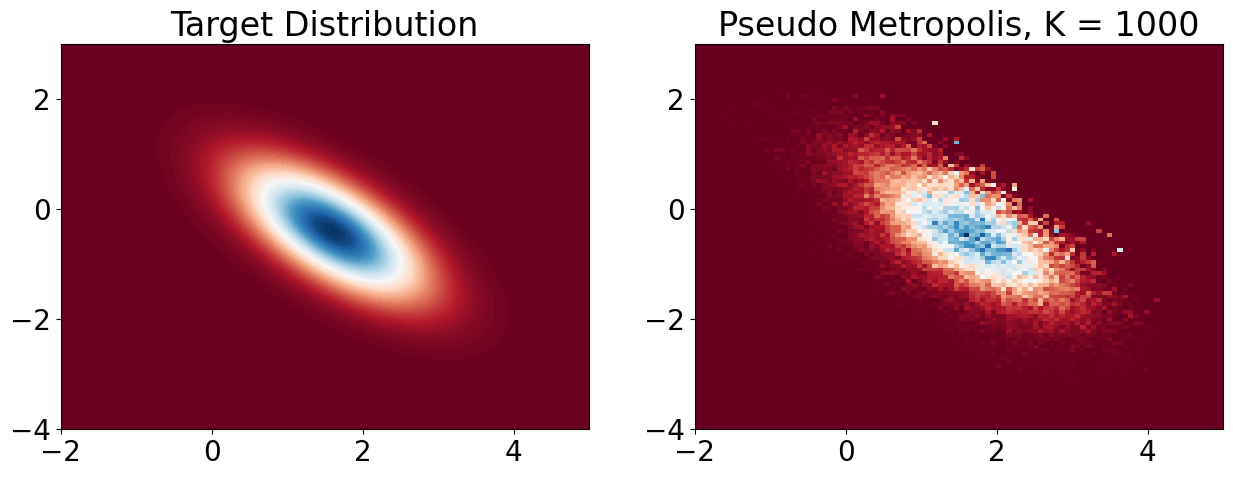

In [10]:
samples_MH = plot_MH(1000, 1, 0.2, use_for_loop=True)

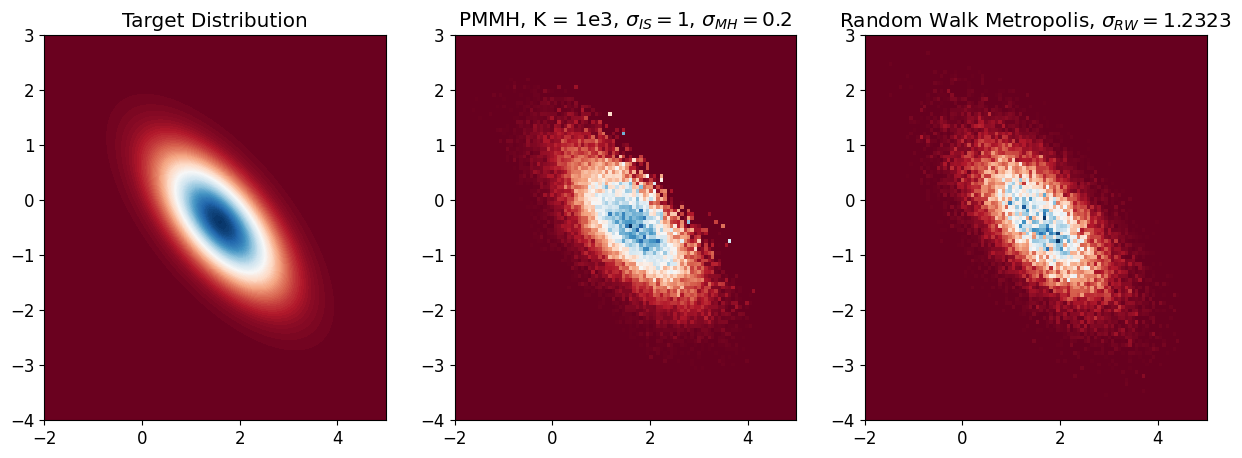

In [11]:
# compare K = 1000 with RWMH
plt.rcParams.update({'font.size': 12})  # Set font size
plt.figure(figsize=(15, 5))

# Contour plot of target distribution
plt.subplot(1, 3, 1)
plt.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
plt.title('Target Distribution')

# Histogram of sampled points
plt.subplot(1, 3, 2)
plt.hist2d(samples_MH[0, :], samples_MH[1, :], 
        100, cmap='RdBu', range=[[-2, 5], [-4, 3]], density=True)
plt.title('PMMH, K = 1e3, $\\sigma_{IS} = 1$, $\\sigma_{MH} = 0.2$')

plt.subplot(1, 3, 3)
plt.hist2d(samples_RW_best[0, burnin:], samples_RW_best[1, burnin:],
                100, cmap='RdBu', range=[[-2, 5], [-4, 3]], density=True)
plt.title('Random Walk Metropolis, $\\sigma_{RW} = 1.2323$')
plt.show()